# Number of edges and inhibition type

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from echo import esn
import time

....................
Elapsed: 13.86 s


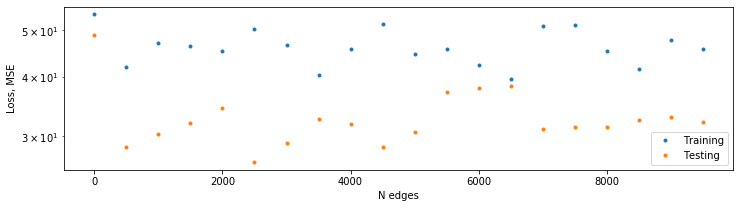

In [20]:
data = esn.Data.create_source('lorenz')

points_to_skip = 300
training_signal_length = 20000
test_length = 500
n_units = 100
n_edge_step = 500
n_experiments = 2

edge_numbers = np.arange(1, n_units*(n_units-1), n_edge_step, dtype=int)

x1,y1 = data.generate(points_to_skip + training_signal_length, sampling_step=0.02, seed=0)
x2,y2 = data.generate(points_to_skip + training_signal_length, sampling_step=0.02, seed=1)

loss = np.ones((len(edge_numbers),2))*np.sum(y1**2) # Training and testing losses

t = time.time()
for i in range(len(edge_numbers)):    
    loss_train = np.zeros(n_experiments)
    loss_test = np.zeros(n_experiments)
    for j in range(n_experiments):
        model = esn.Reservoir(n_units, n_edges=edge_numbers[i], rho=0.8,
                              network_type='erdos', inhibition='distributed', weights_in='flat')
        #                      network_type='erdos', inhibition='alternating', weights_in='alternating')
        model.fit(x1, y1, skip=points_to_skip)

        # Training data loss    
        z = model.predict(x1, length=points_to_skip+test_length)     
        loss_train[j] = esn.utils.loss(y1[points_to_skip:(points_to_skip+test_length)], z[points_to_skip:])

        # Testing loss        
        z = model.predict(x2, length=points_to_skip+test_length)     
        loss_test[j] = esn.utils.loss(y2[points_to_skip:(points_to_skip+test_length)], z[points_to_skip:])
    
    loss[i,0] = min(loss_train)
    loss[i,1] = min(loss_test)
    print('.', end='')

print(f'\nElapsed: {time.time() - t:4.2f} s')

    
plt.figure(figsize=(12,3));
plt.plot(edge_numbers, loss, '.');
plt.yscale('log')
plt.xlabel('N edges');
plt.ylabel('Loss, MSE');
plt.legend(labels=['Training', 'Testing']);

### Below - a saved version of the same plot for a case of "classic" alternating weights

(both input and internal)

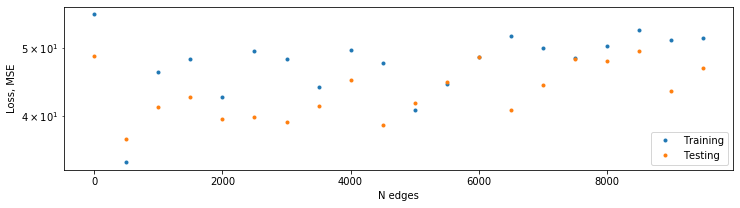

In [7]:
plt.figure(figsize=(12,3));
plt.plot(edge_numbers, loss, '.');
plt.yscale('log')
plt.xlabel('N edges');
plt.ylabel('Loss, MSE');
plt.legend(labels=['Training', 'Testing']);

### Same, but before ρ=0.95 was forced

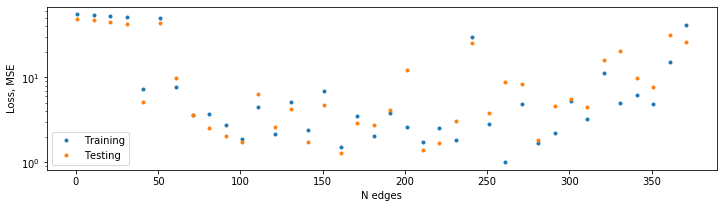

In [19]:
plt.figure(figsize=(12,3));
plt.plot(edge_numbers, loss, '.');
plt.yscale('log')
plt.xlabel('N edges');
plt.ylabel('Loss, MSE');
plt.legend(labels=['Training', 'Testing']);